In [12]:
import torch, os, copy, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

from src.mechanism_base import *
from src.model_base import EmbedMLP
from src.utils import cross_entropy_high_precision, acc_rate

# Check if GPU is available
os.environ["CUDA_VISIBLE_DEVICES"] = os.environ.get("VSCODE_PROXY_CUDA_DEVICE", "")
# os.environ["CUDA_VISIBLE_DEVICES"] = os.environ["VSCODE_PROXY_CUDA_DEVICE"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loading on device: {device}")

plt.rcParams['mathtext.fontset'] = 'cm'


Loading on device: cpu


In [13]:
# Define the base path where the model and data files are stored
# base_path = 'saved_models/p_43_dmodel_43_dmlp_128_act_ReLU_decay_0.2_fractrain_0.4_DFT_06071805' # 400
base_path = '../saved_models/p_43_dmodel_43_dmlp_128_act_ReLU_decay_0.2_fractrain_0.25_DFT_06071850' # 2000

# Set model configuration parameters
d_vocab, d_model, d_mlp, act_type = 43, 43, 128, 'ReLU'  # Vocabulary size, model dimension, MLP size, and activation type
p = d_vocab  # Assign vocabulary size to variable `p`

# Define the file names for the model and data files
model_file = '3000.pth'#'final.pth'        # File containing the trained model
train_data_file = 'train_data.pth'  # File containing the training data
test_data_file = 'test_data.pth'   # File containing the test data

# Load the model and data on the specified device
# Note: The `weights_only=True` argument assumes a custom loader function or a modified PyTorch function. 
# It is not standard in PyTorch's `torch.load`. This should be clarified or corrected.
model_data = torch.load(
    os.path.join(base_path, model_file),   # Path to the model file
    weights_only=True,                    # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                   # Specify the device to load the model onto
)
print(f"Trained Model Dict: {model_data.keys()}\n")  # Print the keys of the loaded model dictionary

# Load the training and testing data
train_data = torch.load(
    os.path.join(base_path, train_data_file),  # Path to the training data file
    weights_only=True,                         # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                        # Specify the device to load the data onto
)
test_data = torch.load(
    os.path.join(base_path, test_data_file),   # Path to the testing data file
    weights_only=True,                         # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                        # Specify the device to load the data onto
)

# Extract the model parameters from the loaded model dictionary
model_load = model_data["model"]  # Access the model section of the dictionary
for key in model_load.keys():
    # Print each model parameter's key and its shape in a formatted manner
    print(f"{key:<30} {str(model_load[key].shape):<25}")

Trained Model Dict: dict_keys(['model', 'train_loss', 'test_loss', 'grad_norm', 'param_norm', 'test_accuracy', 'train_accuracy', 'epoch'])

embed.W_E                      torch.Size([43, 43])     
mlp.W_in                       torch.Size([128, 43])    
mlp.W_out                      torch.Size([43, 128])    
mlp.basis                      torch.Size([43, 43])     


In [14]:
all_data = torch.tensor([(i, j) for i in range(p) for j in range(p)]).to(device)
all_labels = torch.tensor([(i + j) % p for i, j in all_data]).to(device)
train_labels = torch.tensor([(i + j) % p for i, j in train_data]).to(device)

fourier_basis, fourier_basis_names = get_fourier_basis(p, device)
fourier_basis_unstd, _ = get_fourier_basis_unstd(p, device)

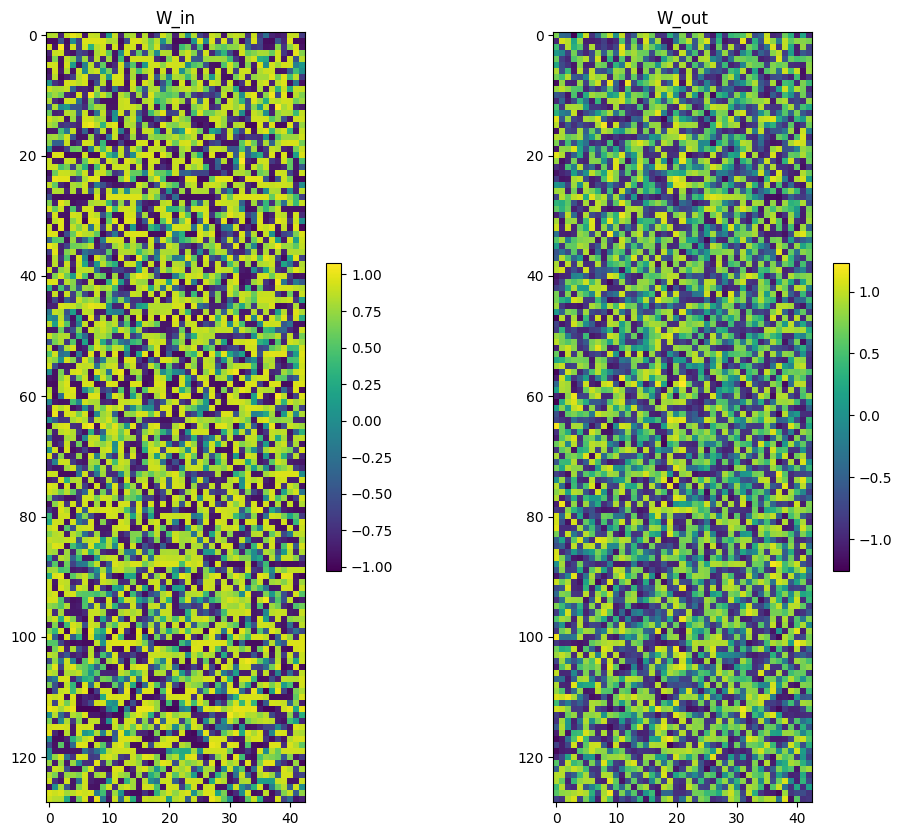

In [15]:
# Plot all four figures in one row
plt.figure(figsize=(12, 10))

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 1)
#plt.imshow(model_load['mlp.W_in'] @ model_load['embed.W_E'], cmap='viridis')
plt.imshow(model_load['mlp.W_in'], cmap='viridis')
plt.title(f'W_in')
plt.colorbar(shrink=0.4)

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 2) 
plt.imshow(model_load['mlp.W_out'].T, cmap='viridis')
plt.title(f'W_out')
plt.colorbar(shrink=0.4)

plt.show()

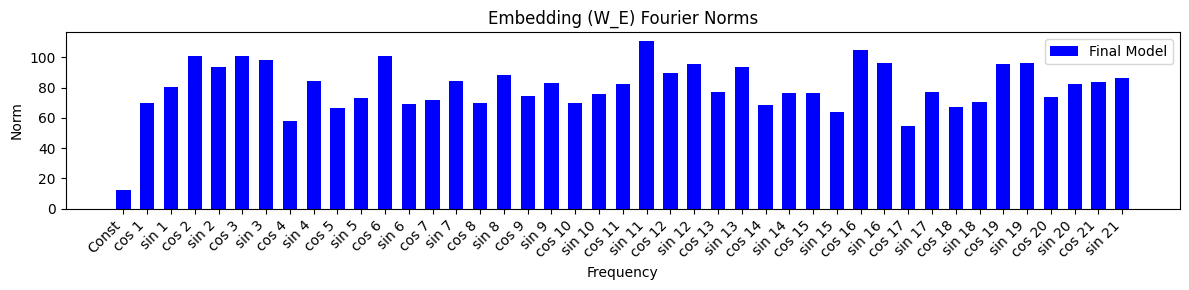

In [16]:
# Compute the norms of the Fourier components
#norms = (model_load['mlp.W_in'] @ model_load['embed.W_E'] @ fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()
norms = (model_load['mlp.W_out'].T @ fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()
#norms = (model_load['mlp.W_in']@ fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()

# Plot the bar plot for "embed.W_E"
fig, ax = plt.subplots(figsize=(12, 3))

# x-axis labels
labels = fourier_basis_names
x = np.arange(len(labels))  # Frequency indices
width = 0.6  # Width of the bars

# Plot bars for the final model
ax.bar(x, norms, width, label="Final Model", color="blue")

# Customize plot
ax.set_title("Embedding (W_E) Fourier Norms")
ax.set_ylabel("Norm")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

# Add x-axis label and adjust layout
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

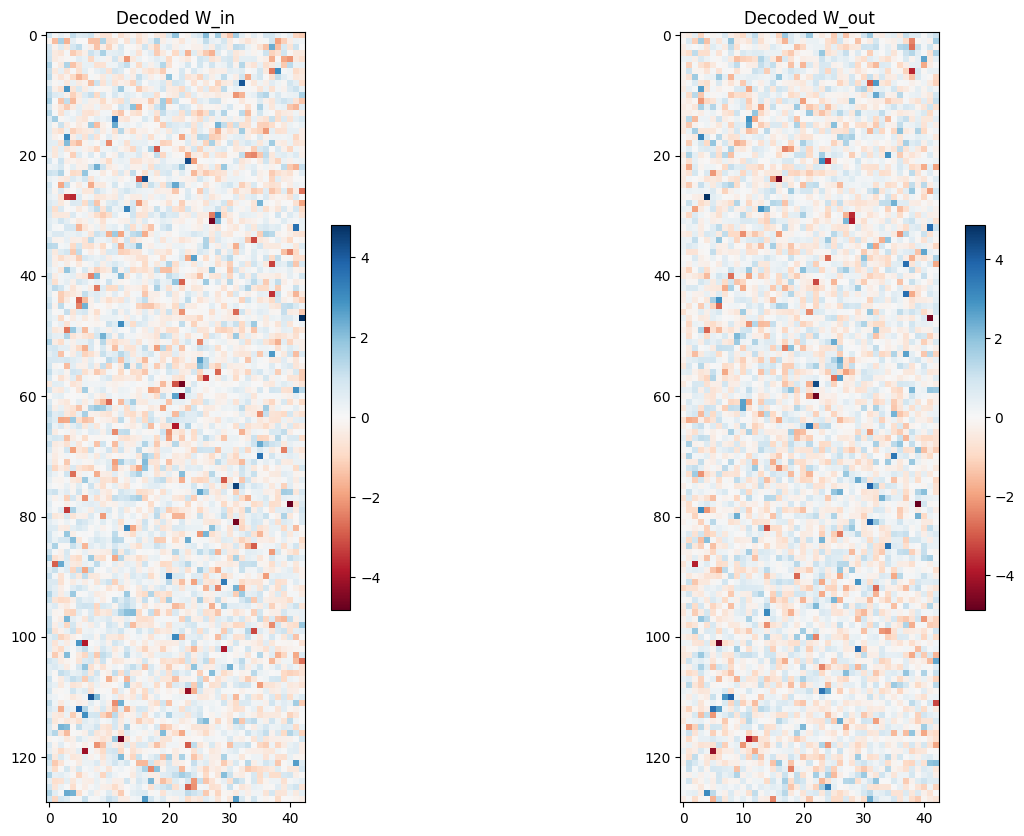

In [17]:
# Plot all four figures in one row
plt.figure(figsize=(15, 10))

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 1)
#data = model_load['mlp.W_in'] @ model_load['embed.W_E'] @ fourier_basis.T
data = model_load['mlp.W_in'] @ fourier_basis.T
abs_max = np.abs(data).max()
plt.imshow(data, cmap='RdBu', vmin=-abs_max, vmax=abs_max)
plt.title(f'Decoded W_in')
plt.colorbar(shrink=0.5)

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 2)
data = model_load['mlp.W_out'].T @ fourier_basis.T
abs_max = np.abs(data).max()
plt.imshow(data, cmap='RdBu', vmin=-abs_max, vmax=abs_max)
plt.title(f'Decoded W_out')
plt.colorbar(shrink=0.5)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")

plt.show()

In [18]:
def decode_weights(model_load, fourier_basis_unstd):
    """
    Decodes the weights using the given model and Fourier basis, and computes the maximum frequency list.

    Parameters:
        model_load (dict): A dictionary containing the model's weights.
        fourier_basis_unstd (torch.Tensor): The Fourier basis matrix.

    Returns:
        tuple: A tuple containing:
            - W_in_decode (torch.Tensor): Decoded weights for W_in.
            - W_out_decode (torch.Tensor): Decoded weights for W_out.
            - max_freq_ls (list): List of maximum frequencies derived from W_in_decode.
    """
    # Decode the weights
    #W_in_decode = model_load['mlp.W_in'] @ model_load['embed.W_E'] @ fourier_basis_unstd.T
    W_in_decode = model_load['mlp.W_in'] @ fourier_basis_unstd.T
    W_out_decode = model_load['mlp.W_out'].T @ fourier_basis_unstd.T

    # Find the maximum frequency list
    max_ls = torch.argmax(abs(W_in_decode), dim=1)
    max_freq_ls = [(id.item() + 1) // 2 for id in max_ls]

    return W_in_decode, W_out_decode, max_freq_ls

In [19]:
W_in_decode, W_out_decode, max_freq_ls = decode_weights(model_load, fourier_basis)
coeff_in_scale_ls_all = []
coeff_out_scale_ls_all = []
coeff_phi_ls_all = []
coeff_psi_ls_all = []

for neuron in range(d_mlp):
    coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
    coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
    coeff_in_scale_ls_all.append(coeff_in_scale)
    coeff_phi_ls_all.append(coeff_in_phi)
    coeff_psi_ls_all.append(coeff_out_phi)
    print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]} , Scale {coeff_in_scale:.2f},{coeff_out_scale:.2f}, 2*Phi(in) {normalize_to_pi(2*coeff_in_phi):.2f}, Phi(out) {coeff_out_phi:.2f}")

Neuron 0: Freq 13 , Scale 2.23,1.34, 2*Phi(in) -2.45, Phi(out) -2.70
Neuron 1: Freq 19 , Scale 2.14,2.53, 2*Phi(in) 2.28, Phi(out) 1.94
Neuron 2: Freq 19 , Scale 2.79,3.05, 2*Phi(in) 1.10, Phi(out) 1.05
Neuron 3: Freq 14 , Scale 1.79,1.12, 2*Phi(in) 0.69, Phi(out) 0.09
Neuron 4: Freq 20 , Scale 2.83,2.60, 2*Phi(in) -1.70, Phi(out) -1.41
Neuron 5: Freq 0 , Scale 1.49,0.06, 2*Phi(in) 0.00, Phi(out) 0.00
Neuron 6: Freq 19 , Scale 3.90,3.87, 2*Phi(in) 1.74, Phi(out) 1.86
Neuron 7: Freq 10 , Scale 1.96,1.26, 2*Phi(in) 2.81, Phi(out) 3.06
Neuron 8: Freq 16 , Scale 4.16,4.03, 2*Phi(in) -2.77, Phi(out) -2.39
Neuron 9: Freq 2 , Scale 2.87,2.74, 2*Phi(in) 0.45, Phi(out) 0.25
Neuron 10: Freq 16 , Scale 2.69,2.55, 2*Phi(in) -1.30, Phi(out) -1.38
Neuron 11: Freq 10 , Scale 2.18,2.10, 2*Phi(in) 1.43, Phi(out) 1.29
Neuron 12: Freq 7 , Scale 2.04,2.02, 2*Phi(in) -2.61, Phi(out) 2.98
Neuron 13: Freq 17 , Scale 1.55,1.21, 2*Phi(in) -0.18, Phi(out) -0.20
Neuron 14: Freq 6 , Scale 3.70,3.43, 2*Phi(in) 0.2

# Process Checking

In [20]:
all_files = [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))]

loaded_files = {} # Initialize the dictionary to store the loaded files
exclude_files = {'final.pth', 'test_data.pth', 'train_data.pth'} # Define the files to exclude

# Loop through all files in the directory
for file_name in os.listdir(base_path):
    file_path = os.path.join(base_path, file_name)
    # Check if it's a file, has the correct extension, and is not in the exclude list
    if os.path.isfile(file_path) and file_name.endswith('.pth') and file_name not in exclude_files:
        # Extract the final ID from the filename (remove extension and convert to int)
        final_id = int(os.path.splitext(file_name)[0])
        # Load the file (assuming it's a PyTorch model)
        loaded_files[final_id] = torch.load(file_path, weights_only=True, map_location=device)["model"]
loaded_files = {key: loaded_files[key] for key in sorted(loaded_files)}

In [21]:
def plot_model(key):
    # Retrieve the model state dict using the selected key
    model_load = loaded_files[key]
    
    # Create the figure with two subplots
    plt.figure(figsize=(15, 10))
    
    # First subplot: Decoded W_in
    plt.subplot(1, 2, 1)
    # Compute data (example: W_in multiplied by the transpose of the fourier_basis)
    data_in = model_load['mlp.W_in'] @ fourier_basis.T
    abs_max_in = np.abs(data_in).max()
    plt.imshow(data_in, cmap='RdBu', vmin=-abs_max_in, vmax=abs_max_in)
    plt.title('Decoded W_in')
    plt.colorbar(shrink=0.5)
    
    # Second subplot: Decoded W_out
    plt.subplot(1, 2, 2)
    # Compute data (example: transpose of W_out multiplied by the transpose of the fourier_basis)
    data_out = model_load['mlp.W_out'].T @ fourier_basis.T
    abs_max_out = np.abs(data_out).max()
    plt.imshow(data_out, cmap='RdBu', vmin=-abs_max_out, vmax=abs_max_out)
    plt.title('Decoded W_out')
    plt.colorbar(shrink=0.5)

    plt.suptitle(f'Model Key: {key}')
    plt.show()

# Create a selection slider with the sorted keys from your loaded_files dictionary
key_options = sorted(loaded_files.keys())
interact(plot_model, key=widgets.SelectionSlider(options=key_options, description='Model Key'));


interactive(children=(SelectionSlider(description='Model Key', options=(0, 1000, 2000, 3000, 4000, 5000, 6000,…

In [28]:
def interactive_model(key):
    # Clear previous outputs so the new model's output is shown clearly
    clear_output(wait=True)
    
    # Retrieve the model using the selected key
    model_load = loaded_files[key]
    
    # Decode the weights from the selected model
    W_in_decode, W_out_decode, max_freq_ls = decode_weights(model_load, fourier_basis)
    #sparse_level = (W_in_decode.norm(p=4, dim=1)**4/W_in_decode.norm(p=2, dim=1)**4)/2 + (W_out_decode.norm(p=4, dim=1)**4/W_out_decode.norm(p=2, dim=1)**4)/2
    
    # Determine the number of neurons (assuming the first dimension of W_in_decode equals d_mlp)
    d_mlp = W_in_decode.shape[0]
    print(f"Loaded Model Key: {key} with {d_mlp} neurons.\n")
    
    # Loop through each neuron and print the computed details
    for neuron in range(d_mlp):
        coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
        coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
        sparsity = (coeff_in_scale**2+coeff_out_scale**2)/(W_in_decode.norm(p=2, dim=1)[neuron]**2+W_out_decode.norm(p=2, dim=1)[neuron]**2)
        print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]}, "
              f"Scale {coeff_in_scale:.4f},{coeff_out_scale:.4f}, "
              f"2*Phi(in) {normalize_to_pi(2*coeff_in_phi):.2f}, "
              f"Phi(out) {coeff_out_phi:.2f}",
              f"Sparsity {sparsity:.2f}",
              f"Para Norm {model_load['mlp.W_in'].norm(p=2, dim=1)[neuron]:.2f}",
              f"Para Norm {model_load['mlp.W_out'].T.norm(p=2, dim=1)[neuron]:.2f}")
              #f"Scale Diff {coeff_in_scale**2-2*coeff_out_scale**2:.8f}")

    print(f"Para Norm All {model_load['mlp.W_in'].norm(p=2):.2f}")
# Create an interactive widget for model selection using the keys in loaded_files.
model_keys = sorted(loaded_files.keys())
interact(interactive_model, key=widgets.SelectionSlider(options=model_keys, description='Model Key'));

interactive(children=(SelectionSlider(description='Model Key', options=(0, 1000, 2000, 3000, 4000, 5000, 6000,…